In [1]:
# Importiamo tutte le librerie
# Librerie destinate a capire se la scheda video è stata individuata
from distutils.version import LooseVersion
import warnings
# Pandas è una libreria destinata all'analisi dati comprendente un numeroso numero di funzioni
import pandas as pd
# Numpy è una libreria destana al calcolo vettoriale e matriciale
import numpy as np
# Matplotlib è una libreria per la creazione di grafici
import matplotlib.pyplot as plt
# TensorFlow è una libreria software open source usata nell'apprendimento automatico
import tensorflow as tf

# Necessarie per l'inizializzazione dei pesi
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

#Librerie necessarie per la realizzazione del modello 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import activations

from tensorflow.keras import optimizers
optimizers.RMSprop
optimizers.Adam

keras.optimizer_v2.adam.Adam

In [2]:
# Verifichiamo che la GPU sia montata correttamente e controlliamo la versione di Tensorflow installata
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.7.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: No GPU found. Please ensure you have installed TensorFlow correctly
  


In [3]:
# Importiamo i dataset
from google.colab import drive
drive.mount('/content/gdrive')
test = 'gdrive/MyDrive/DeMaCS_Project_Data-20211205T142328Z-001/DeMaCS_Project_Data/task1_next_value_prediction/test.csv'
train = 'gdrive/MyDrive/DeMaCS_Project_Data-20211205T142328Z-001/DeMaCS_Project_Data/task1_next_value_prediction/train.csv'
train = pd.read_csv(train)
test = pd.read_csv(test)
train = train['x'].values.reshape(-1,1)
test = test['x'].values.reshape(-1,1)
print(train.shape)
print(test.shape)

Mounted at /content/gdrive
(144911, 1)
(148371, 1)


Text(0, 0.5, 'x values')

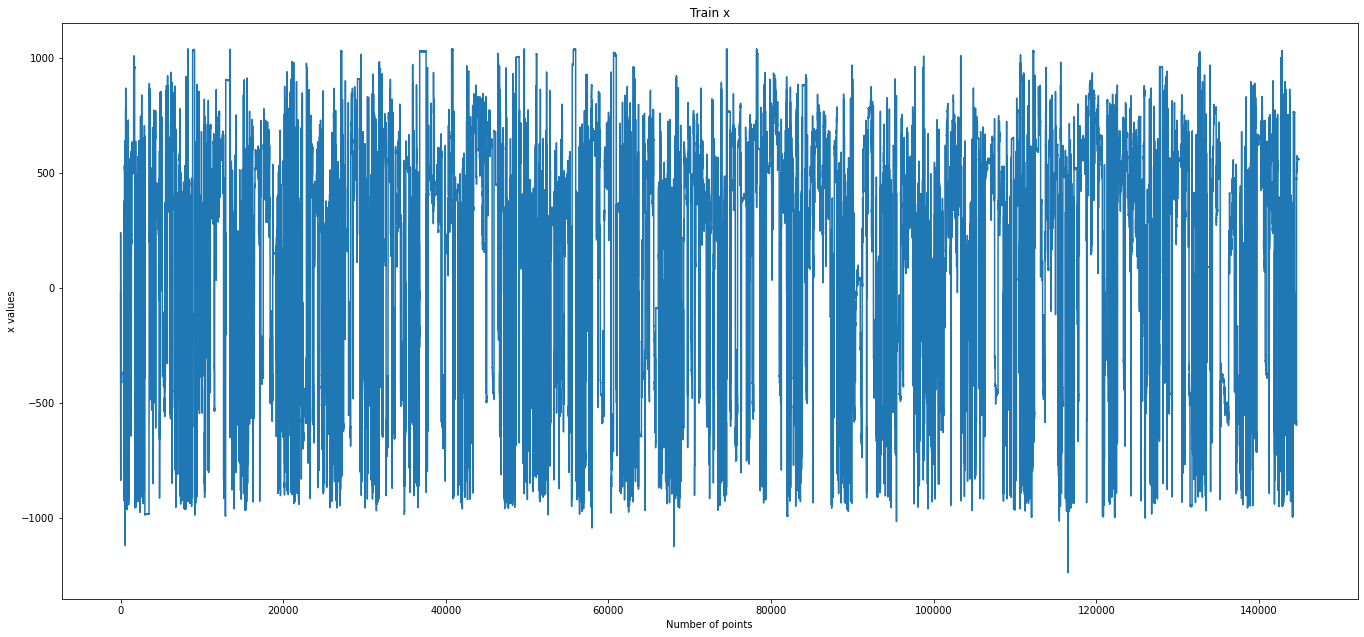

In [4]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.title('Train x')
plt.plot(train)
plt.xlabel('Number of points')
plt.ylabel('x values')

Text(0, 0.5, 'x values')

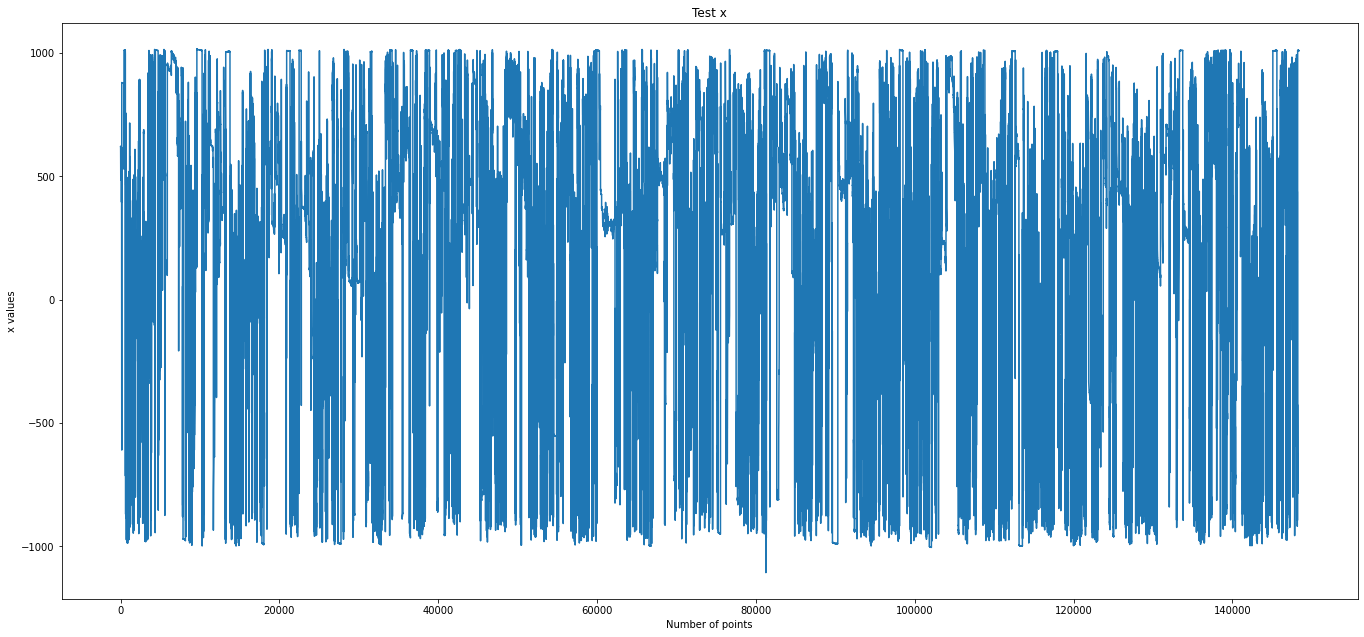

In [5]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.title('Test x')
plt.plot(test)
plt.xlabel('Number of points')
plt.ylabel('x values')

In [6]:
# normalizziamo i dataset

size_train = 110000
scaled_train = (train - min(train))
minimo_train =  min(train)
massimo_train = max(scaled_train)
scaled_train = scaled_train/max(scaled_train)
scaled_val = scaled_train[size_train:]
scaled_train= scaled_train[:size_train]
scaled_test = (test- min(minimo_train))/massimo_train

Text(0, 0.5, 'x values')

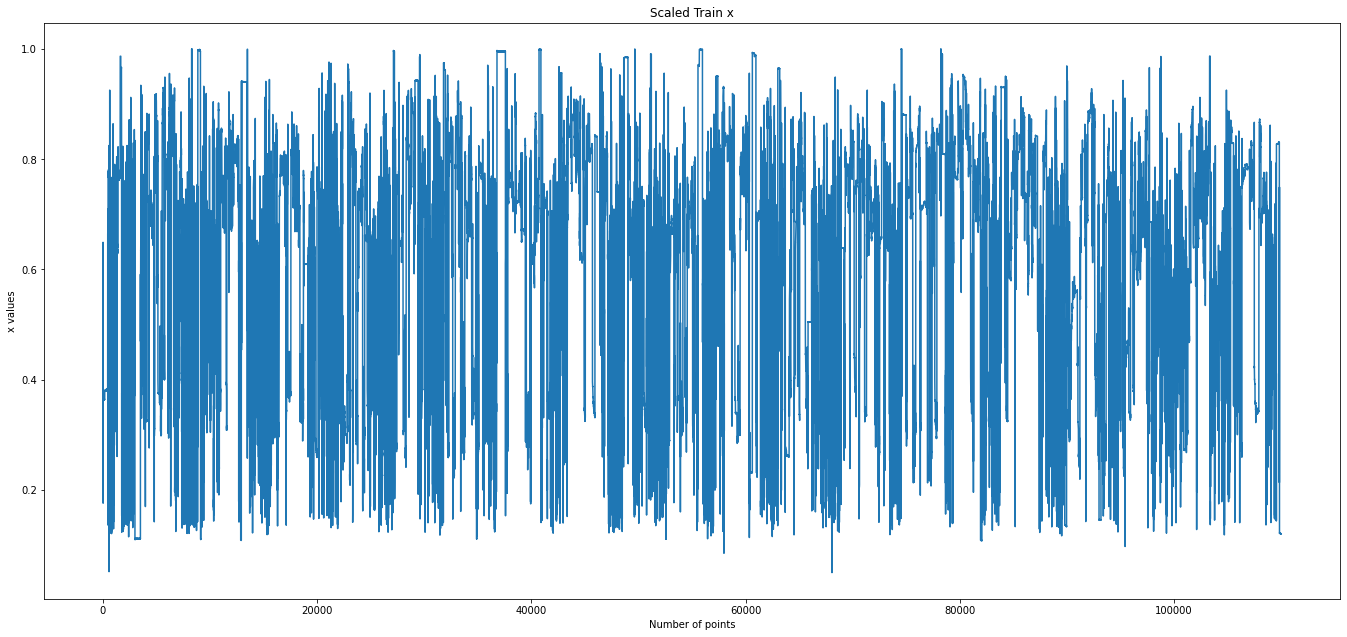

In [7]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.title('Scaled Train x')
plt.plot(scaled_train)
plt.xlabel('Number of points')
plt.ylabel('x values')

Text(0, 0.5, 'x values')

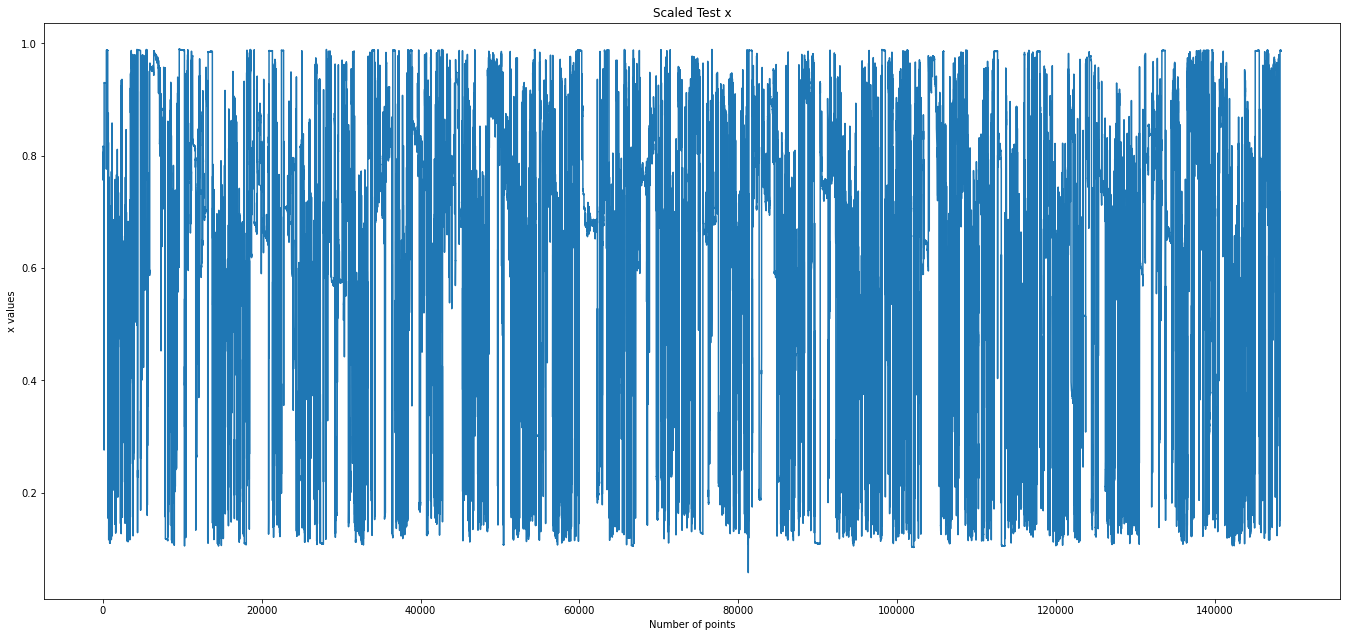

In [8]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.title('Scaled Test x')
plt.plot(scaled_test)
plt.xlabel('Number of points')
plt.ylabel('x values')

In [9]:
lookback = 30 # Indietro di 5 minuti
window_shift = 6 #Avanti di 1 minuto

In [10]:
# Tramite il generator è possibile definire i tensori necessarari nel modello

def generator(data, lookback,  min_index, max_index,window_shift=window_shift):
  dim_samples = ((len(data)- lookback +  window_shift-1 )//window_shift, lookback,1)
  dim_target = ((len(data)- lookback +  window_shift-1 )//window_shift,)
  samples = np.zeros(dim_samples)
  target = np.zeros(dim_target)
  i=0
  j=0
  while i<(len(data) - lookback +  window_shift-1)//window_shift:
    for k in range(0, lookback,1):
      samples[i,k,0] =data[i*window_shift+k]
    target [i]=data[lookback + i*window_shift] 
    i +=1
    j+= lookback
  return samples, target

In [11]:
x_train, y_train = generator(scaled_train, lookback = lookback,min_index = 0, max_index = len(scaled_train)-1 , window_shift = window_shift)
x_val, y_val = generator(scaled_val, lookback = lookback,min_index = 0, max_index = len(scaled_val))
x_test, y_test = generator(scaled_test, lookback = lookback, min_index = 0, max_index = len(scaled_test))

In [12]:
seq_len = x_train.shape[1]
num_feat = 1
print(seq_len)
print(num_feat)
print(x_train.shape)
print(type(x_train))

30
1
(18329, 30, 1)
<class 'numpy.ndarray'>


In [13]:
# Definiamo il modello
model = Sequential()
model.add((layers.GRU(16, input_shape = (seq_len, num_feat), return_sequences = True, activation = 'relu' )))
model.add((layers.GRU(8, input_shape = (seq_len, num_feat ), return_sequences = False)))
model.add(layers.Dense(32))
model.add(layers.Dense(16))
model.add(layers.Dense(8))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 16)            912       
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainabl

In [14]:
# Effettuiamo un fit dei dati di train
print(massimo_train)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose =1, batch_size=128) #Best Fit per z

[2278]
Epoch 1/20
144/144 [==============================] - 9s 35ms/step - loss: 0.0444 - mae: 0.1274 - val_loss: 0.0050 - val_mae: 0.0372
Epoch 2/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0052 - mae: 0.0359 - val_loss: 0.0043 - val_mae: 0.0308
Epoch 3/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0046 - mae: 0.0333 - val_loss: 0.0038 - val_mae: 0.0268
Epoch 4/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0043 - mae: 0.0317 - val_loss: 0.0037 - val_mae: 0.0341
Epoch 5/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0042 - mae: 0.0305 - val_loss: 0.0036 - val_mae: 0.0334
Epoch 6/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0041 - mae: 0.0300 - val_loss: 0.0034 - val_mae: 0.0245
Epoch 7/20
144/144 [==============================] - 4s 31ms/step - loss: 0.0040 - mae: 0.0294 - val_loss: 0.0036 - val_mae: 0.0341
Epoch 8/20
144/144 [==============================] - 4s 31ms/

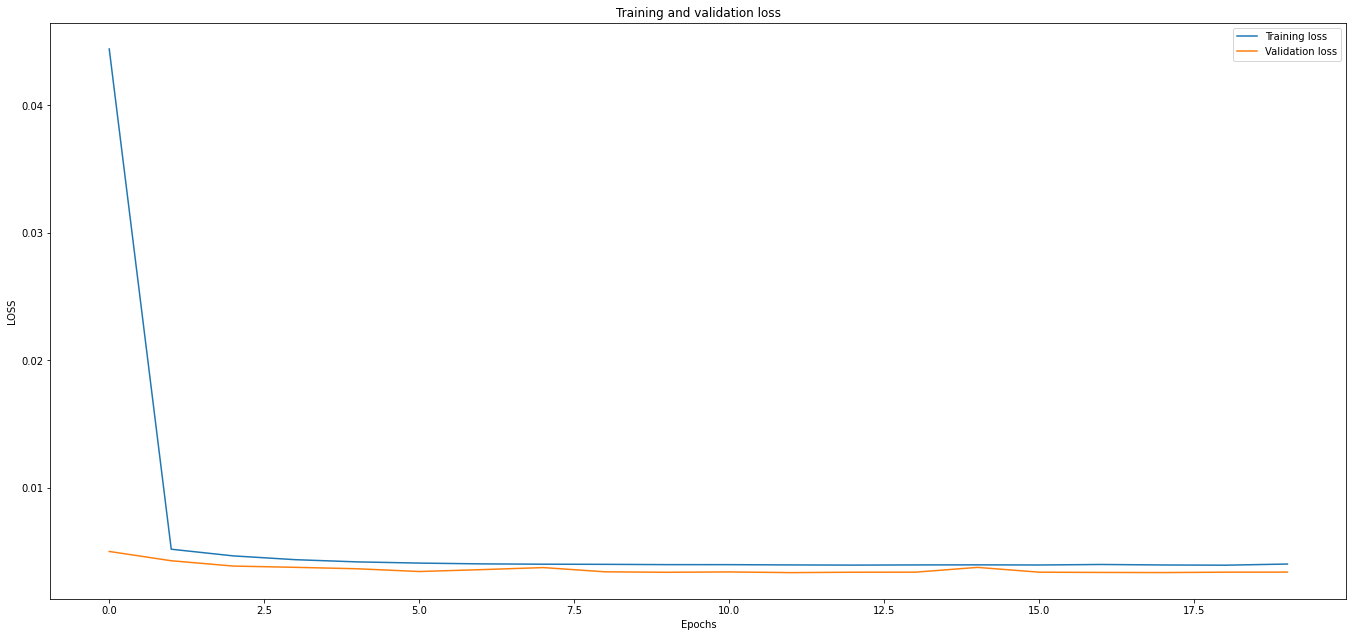

In [15]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.show()

In [16]:
LOSS = history.history['loss'][-1]
MAE = history.history['mae'][-1]
VAL_LOSS = history.history['val_loss'][-1]
VAL_MAE = history.history['val_mae'][-1]

In [17]:
last_train_batch =x_test
previsioni = model.predict(last_train_batch)
previsioni = previsioni.reshape(-1)

In [18]:
# Calcoliamo la MAE DI TEST
differenza_test = np.absolute(previsioni -y_test)*massimo_train
TEST_MAE = sum(differenza_test)/len(differenza_test)
print('LOSS= ',LOSS*massimo_train)
print('MAE= ',MAE*massimo_train)
print('VAL_LOSS= ',VAL_LOSS*massimo_train)
print('VAL_MAE= ',VAL_MAE*massimo_train)
print('TEST_MAE= ',TEST_MAE)

LOSS=  [9.10674535]
MAE=  [72.84805637]
VAL_LOSS=  [7.66386772]
VAL_MAE=  [57.88186747]
TEST_MAE=  81.00130604234035


Text(0, 0.5, 'x values')

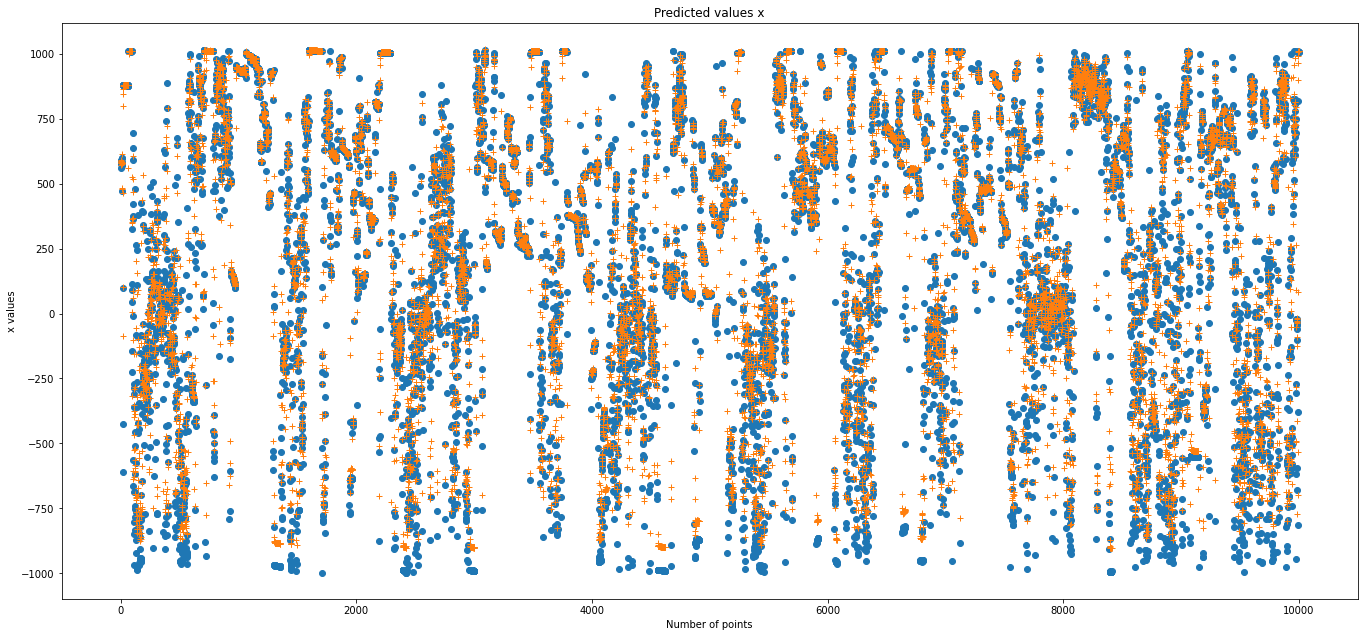

In [19]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.plot(y_test[:10000]*massimo_train+ minimo_train, 'o')
plt.plot(previsioni[:10000]*massimo_train + minimo_train, '+')
plt.title('Predicted values x')
plt.xlabel('Number of points')
plt.ylabel('x values')